In [1]:
import numpy as np
import random
import torch
from torch import nn
import transformers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
from rich import print
import pandas as pd
from datasets import Dataset, Value, ClassLabel, Features, DatasetDict, load_dataset, load_from_disk

2024-08-11 01:15:34.661758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 01:15:34.661834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 01:15:34.663362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 01:15:34.672031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-11 01:15:35.844681: W tensorflow/compiler/tf2

In [2]:
data_path = '../../data/result/sentiment_hf_dataset/'
data = load_from_disk(data_path)

In [3]:
print(f"Training Example:\n{data['train']['text'][0]}")

Training Example:
أكثر ما أعجبني: التطبيق العملي المحدث والمشابه للعمل والقضايا الواقعية لتحليل الأدلة الجنائية التقنية

In [4]:
print(f"Training Data Lengths: {len(data['train'])}")

Training Data Lengths: 951

In [5]:
test_path = '../../data/test_gold_labels/test_with_sentiment_df_majority_vote_gpt4o_preferred.csv'

In [6]:
test_df = pd.read_csv(test_path)

In [7]:
test_df.head()

,text,updated_label
0,أكثر ما أعجبني: المقرر ساعدني جدا في فهم نظام ...,Positive
1,أكثر ما لم يعجبني: المقرر يحتوي على مواضيع ساب...,Negative
2,أكثر ما لم يعجبني: أسلوب شرح المقرر,Negative
3,اقتراحاتي للإضافة: everything is spectacular a...,Positive
4,أكثر ما أعجبني: معلمة المادة متمكنة وتستجيب عل...,Positive


In [8]:
label_names = sorted(data['train'].features['labels'].names)

features = Features(
    {
        'id': Value(dtype='string'),
        'text': Value(dtype='string'),
        'labels': ClassLabel(names=label_names, num_classes=len(label_names), id=None)
    }
)
#################################################################################
test_hf = Dataset.from_dict(
        {
            'id': list(test_df.index.astype(str)),
            'text': list(test_df['text']),
            'labels': list(test_df['updated_label'])
        },
        features=features
    )
#################################################################################
random_state = 42
temp_data = test_hf.train_test_split(test_size=0.5, seed=random_state, stratify_by_column='labels')

In [9]:
label_names

['Negative', 'Neutral', 'Positive']

In [10]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 951
    })
})

In [11]:
data['validation'] = temp_data['train']
data['test'] = temp_data['test']

In [12]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 951
    })
    validation: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 317
    })
    test: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 317
    })
})

In [13]:
print(data['train'].features['labels'].int2str(list(range(len(label_names)))))
print(data['test'].features['labels'].int2str(list(range(len(label_names)))))
print(data['validation'].features['labels'].int2str(list(range(len(label_names)))))

['Negative', 'Neutral', 'Positive']

['Negative', 'Neutral', 'Positive']

['Negative', 'Neutral', 'Positive']

In [14]:
model_checkpoint = 'FacebookAI/xlm-roberta-large'

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [16]:
label_feature = data['train'].features['labels']
label_names = label_feature.names
print(label_names)

['Negative', 'Neutral', 'Positive']

In [17]:
label2id = {label: label_feature.str2int(label) for label in label_names}
id2label = {v: k for k, v in label2id.items()}

In [18]:
print(label2id)
print(id2label)

{'Negative': 0, 'Neutral': 1, 'Positive': 2}

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}

In [19]:
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True)

In [20]:
tokenized_dataset = data.map(tokenize_function, batched=True, remove_columns=['text'])

Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Map:   0%|          | 0/317 [00:00<?, ? examples/s]

In [21]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 951
    })
    validation: Dataset({
        features: ['id', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 317
    })
    test: Dataset({
        features: ['id', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 317
    })
})

In [22]:
tokenized_train = tokenized_dataset['train']
tokenized_validation = tokenized_dataset['validation']
tokenized_test = tokenized_dataset['test']

In [23]:
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint,
        id2label=id2label,
        label2id=label2id
    )

    return model

In [24]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    result = classification_report(labels, predictions, output_dict=True, zero_division=0)
    # print(result)
    metrics = {f'{id2label[int(k)]} f1-score': v['f1-score'] for k, v in result.items() if k.isdigit()}
    metrics['Accuracy'] = result['accuracy']
    metrics['Macro f1-score'] = result['macro avg']['f1-score']
    return metrics

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        y = self.train_dataset['labels']
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=np.array(y))
        class_weights = torch.tensor(class_weights).float().to(device)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [27]:
batch_size = 8
num_epochs = 5

In [28]:
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
transformers.set_seed(random_state)


torch.cuda.manual_seed_all(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [29]:
args = TrainingArguments(
    f'../../models/model_sentiment',
    overwrite_output_dir=True,
    num_train_epochs=num_epochs,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    seed=random_state,
    data_seed=random_state,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=1e-5,
    weight_decay=0.001,
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to='none'
)

trainer = CustomTrainer(
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    data_collator=data_collator,
    tokenizer=tokenizer,
    model_init=model_init,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Negative f1-score,Neutral f1-score,Positive f1-score,Accuracy,Macro f1-score
1,No log,0.559624,0.789916,0.773481,0.910180,0.848580,0.824525
2,No log,0.513931,0.874074,0.879433,0.949721,0.917981,0.901076
3,No log,0.518256,0.863636,0.878378,0.960452,0.921136,0.900822
4,No log,0.506356,0.884058,0.879433,0.957746,0.924290,0.907079
5,0.418100,0.523270,0.897059,0.881119,0.957746,0.927445,0.911975


TrainOutput(global_step=595, training_loss=0.3819273075135816, metrics={'train_runtime': 312.4575, 'train_samples_per_second': 15.218, 'train_steps_per_second': 1.904, 'total_flos': 423582437608116.0, 'train_loss': 0.3819273075135816, 'epoch': 5.0})

In [31]:
predictions = trainer.predict(tokenized_test)

In [32]:
true_labels, preds = predictions.label_ids, predictions.predictions
pred_labels = np.argmax(preds, axis=-1)

print(classification_report(true_labels, pred_labels, target_names=label_names))

precision    recall  f1-score   support

    Negative       0.94      0.83      0.88        71
     Neutral       0.88      0.93      0.91        72
    Positive       0.97      0.99      0.98       174

    accuracy                           0.94       317
   macro avg       0.93      0.92      0.92       317
weighted avg       0.94      0.94      0.94       317

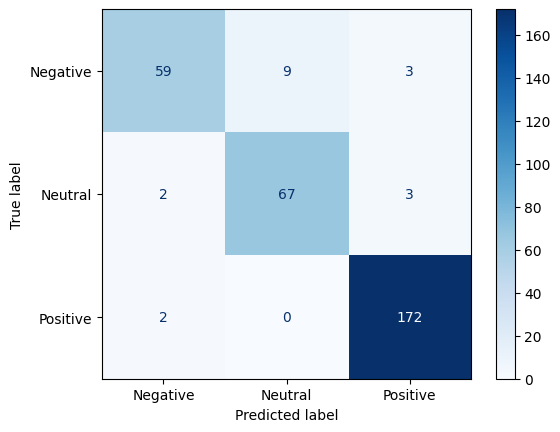

In [33]:
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", colorbar=True)

In [34]:
{
    'test_loss': 1.7518649101257324,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.6222222222222222,
    'test_محتوى ومعلومات المقرر f1-score': 0.5510204081632653,
    'test_الوقت و الجدول f1-score': 0.0,
    'test_دكتور المقرر f1-score': 0.6432748538011696,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.2647058823529412,
    'test_غير محدد f1-score': 0.4210526315789474,
    'test_سوق العمل f1-score': 0.0,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.0,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.0,
    'test_Accuracy': 0.49842271293375395,
    'test_Macro f1-score': 0.2780306664576162,
    'test_runtime': 0.6648,
    'test_samples_per_second': 476.805,
    'test_steps_per_second': 120.329
}

# after first iteration of cleansing on p5000 
{
    'test_loss': 1.5336387157440186,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.627906976744186,
    'test_محتوى ومعلومات المقرر f1-score': 0.6477732793522267,
    'test_الوقت و الجدول f1-score': 0.0,
    'test_دكتور المقرر f1-score': 0.7656250000000001,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.18666666666666668,
    'test_غير محدد f1-score': 0.7391304347826088,
    'test_سوق العمل f1-score': 0.0,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.0,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.0,
    'test_Accuracy': 0.5678233438485805,
    'test_Macro f1-score': 0.3296780397272987,
    'test_runtime': 1.9832,
    'test_samples_per_second': 159.845,
    'test_steps_per_second': 40.339
}

# after first iteration of cleansing on A4000
{
    'test_loss': 1.5463141202926636,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.6666666666666666,
    'test_محتوى ومعلومات المقرر f1-score': 0.6297872340425533,
    'test_الوقت و الجدول f1-score': 0.0,
    'test_دكتور المقرر f1-score': 0.7297297297297296,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.2222222222222222,
    'test_غير محدد f1-score': 0.6538461538461537,
    'test_سوق العمل f1-score': 0.0,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.0,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.0,
    'test_Accuracy': 0.5615141955835962,
    'test_Macro f1-score': 0.32247244516748064,
    'test_runtime': 0.6359,
    'test_samples_per_second': 498.477,
    'test_steps_per_second': 125.798
}

## llama 3 annotation performance on dr reem annotated test data
{
    'test_loss': 0.9754232168197632,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.7397260273972601,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.33999999999999997,
    'test_محتوى ومعلومات المقرر f1-score': 0.7555555555555556,
    'test_دكتور المقرر f1-score': 0.8739495798319328,
    'test_غير محدد f1-score': 0.8372093023255814,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.0,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.5909090909090909,
    'test_سوق العمل f1-score': 0.0,
    'test_الوقت و الجدول f1-score': 0.5,
    'test_Accuracy': 0.6845425867507886,
    'test_Macro f1-score': 0.5152610617799357,
    'test_runtime': 1.3045,
    'test_samples_per_second': 243.012,
    'test_steps_per_second': 61.328
}

## llama 3 annotation performance on llama 3 test annotated data

{
    'test_loss': 1.2718727588653564,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.6373626373626374,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.2926829268292683,
    'test_محتوى ومعلومات المقرر f1-score': 0.6403162055335968,
    'test_دكتور المقرر f1-score': 0.7702702702702704,
    'test_غير محدد f1-score': 0.8333333333333334,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.0,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.0,
    'test_سوق العمل f1-score': 0.0,
    'test_الوقت و الجدول f1-score': 0.7500000000000001,
    'test_Accuracy': 0.637223974763407,
    'test_Macro f1-score': 0.435996152592123,
    'test_runtime': 1.3771,
    'test_samples_per_second': 230.195,
    'test_steps_per_second': 58.093
}

## gpt4o annotation performance on dr reem annotated test set
{
    'test_loss': 1.1878654956817627,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.6464646464646465,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.3018867924528302,
    'test_محتوى ومعلومات المقرر f1-score': 0.7575757575757576,
    'test_دكتور المقرر f1-score': 0.9133858267716536,
    'test_غير محدد f1-score': 0.6909090909090908,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.5384615384615385,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.6538461538461537,
    'test_سوق العمل f1-score': 0.5,
    'test_الوقت و الجدول f1-score': 0.6,
    'test_Accuracy': 0.7034700315457413,
    'test_Macro f1-score': 0.6225033118312967,
    'test_runtime': 1.6649,
    'test_samples_per_second': 190.397,
    'test_steps_per_second': 48.05
}

# majority llm vote performance on llms_human test set (remove_prefix:yes, augment:yes, drop_duplicates:yes)
{
    'test_loss': 1.4566463232040405,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.7317073170731708,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.22857142857142854,
    'test_محتوى ومعلومات المقرر f1-score': 0.6666666666666666,
    'test_دكتور المقرر f1-score': 0.8103448275862069,
    'test_غير محدد f1-score': 0.7428571428571429,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.7199999999999999,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.4727272727272728,
    'test_سوق العمل f1-score': 0.5882352941176471,
    'test_الوقت و الجدول f1-score': 0.56,
    'test_Accuracy': 0.6403785488958991,
    'test_Macro f1-score': 0.6134566610666151,
    'test_runtime': 1.7727,
    'test_samples_per_second': 178.828,
    'test_steps_per_second': 45.13
}

# majority llm vote performance on llms_human test set (remove_prefix:no, augment:yes, drop_duplicates:yes)
{
    'test_loss': 1.5563527345657349,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.7142857142857143,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.23880597014925373,
    'test_محتوى ومعلومات المقرر f1-score': 0.7023809523809522,
    'test_دكتور المقرر f1-score': 0.8034188034188033,
    'test_غير محدد f1-score': 0.7272727272727273,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.8,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.44067796610169496,
    'test_سوق العمل f1-score': 0.6666666666666665,
    'test_الوقت و الجدول f1-score': 0.39999999999999997,
    'test_Accuracy': 0.6403785488958991,
    'test_Macro f1-score': 0.6103898666973125,
    'test_runtime': 1.9864,
    'test_samples_per_second': 159.589,
    'test_steps_per_second': 40.275
}

# majority llm vote performance on llms_human test set (remove_prefix:no, augment:no, drop_duplicates:yes)
{
    'test_loss': 1.0261039733886719,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.686868686868687,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.18181818181818182,
    'test_محتوى ومعلومات المقرر f1-score': 0.7956989247311829,
    'test_دكتور المقرر f1-score': 0.9032258064516129,
    'test_غير محدد f1-score': 0.8266666666666665,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.6956521739130435,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.5937499999999999,
    'test_سوق العمل f1-score': 0.16666666666666669,
    'test_الوقت و الجدول f1-score': 0.4444444444444445,
    'test_Accuracy': 0.7255520504731862,
    'test_Macro f1-score': 0.5883101723956096,
    'test_runtime': 2.0741,
    'test_samples_per_second': 152.836,
    'test_steps_per_second': 38.57
}

# majority llm vote with gpt4o augmentation performance on llms_human test set (remove_prefix: no)
{
    'test_loss': 1.0483810901641846,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.8148148148148148,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.6461538461538462,
    'test_الوقت و الجدول f1-score': 0.6470588235294117,
    'test_دكتور المقرر f1-score': 0.8524590163934426,
    'test_سوق العمل f1-score': 0.6,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.43750000000000006,
    'test_غير محدد f1-score': 0.7567567567567567,
    'test_محتوى ومعلومات المقرر f1-score': 0.6466165413533835,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.8,
    'test_Accuracy': 0.7066246056782335,
    'test_Macro f1-score': 0.6890399776668505,
    'test_runtime': 1.3802,
    'test_samples_per_second': 229.67,
    'test_steps_per_second': 57.961
}


# majority llm vote with gpt4o 3 examples on minority classes augmentation performance on llms_human test set (remove_prefix: no, batch_size=8, trainer)
{
    'test_loss': 0.8945626616477966,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.8799999999999999,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.7234042553191491,
    'test_الوقت و الجدول f1-score': 0.6250000000000001,
    'test_دكتور المقرر f1-score': 0.8739495798319329,
    'test_سوق العمل f1-score': 0.6086956521739131,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.4857142857142857,
    'test_غير محدد f1-score': 0.7761194029850748,
    'test_محتوى ومعلومات المقرر f1-score': 0.735483870967742,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.7708333333333333,
    'test_Accuracy': 0.7381703470031545,
    'test_Macro f1-score': 0.7199111533694924,
    'test_runtime': 1.1083,
    'test_samples_per_second': 286.03,
    'test_steps_per_second': 36.092
}

# majority llm vote with gpt4o 3 examples on minority classes augmentation performance on llms_human test set (remove_prefix: no, batch_size=8, custom_trainer)

{
    'test_loss': 0.9001050591468811,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.7586206896551724,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.6956521739130435,
    'test_الوقت و الجدول f1-score': 0.6153846153846153,
    'test_دكتور المقرر f1-score': 0.8411214953271028,
    'test_سوق العمل f1-score': 0.5714285714285713,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.5000000000000001,
    'test_غير محدد f1-score': 0.7647058823529411,
    'test_محتوى ومعلومات المقرر f1-score': 0.7590361445783134,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.7676767676767676,
    'test_Accuracy': 0.7287066246056783,
    'test_Macro f1-score': 0.697069593368503,
    'test_runtime': 1.1432,
    'test_samples_per_second': 277.295,
    'test_steps_per_second': 34.99
}


# majority llm vote with gpt4o 3 examples on minority classes augmentation performance on llms_human test set (remove_prefix: no, batch_size=8, trainer)

{
    'test_loss': 0.8945626616477966,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.8799999999999999,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.7234042553191491,
    'test_الوقت و الجدول f1-score': 0.6250000000000001,
    'test_دكتور المقرر f1-score': 0.8739495798319329,
    'test_سوق العمل f1-score': 0.6086956521739131,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.4857142857142857,
    'test_غير محدد f1-score': 0.7761194029850748,
    'test_محتوى ومعلومات المقرر f1-score': 0.735483870967742,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.7708333333333333,
    'test_Accuracy': 0.7381703470031545,
    'test_Macro f1-score': 0.7199111533694924,
    'test_runtime': 1.1097,
    'test_samples_per_second': 285.652,
    'test_steps_per_second': 36.044
}

# ../../data/result/hf_dataset_aug_gpt4o, roberta base custom trainer batchsize:8
{
    'test_loss': 0.7793468236923218,
    'test_الجانب البحثي و الأوراق البحثية f1-score': 0.9166666666666666,
    'test_المتطلبات و المهام و الدرجات f1-score': 0.7083333333333334,
    'test_الوقت و الجدول f1-score': 0.6451612903225806,
    'test_دكتور المقرر f1-score': 0.90625,
    'test_سوق العمل f1-score': 0.6,
    'test_طريقة تدريس و تقديم المادة f1-score': 0.5818181818181818,
    'test_غير محدد f1-score': 0.7647058823529411,
    'test_محتوى ومعلومات المقرر f1-score': 0.7160493827160493,
    'test_موازنة الجزء العملي مع الجزء النظري f1-score': 0.8163265306122449,
    'test_Accuracy': 0.7634069400630915,
    'test_Macro f1-score': 0.7394790297579997,
    'test_runtime': 0.9954,
    'test_samples_per_second': 318.468,
    'test_steps_per_second': 40.185
}

print()